In [2]:
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay,precision_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score
import numpy as np
import optuna
from sklearn.metrics import precision_recall_curve, auc
from sklearn.ensemble import VotingClassifier

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = './playground-series-s4e1/'
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)

In [4]:
#inspect the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [5]:
#further check null value
null_col = pd.DataFrame()
for col in train_df.columns:
    null_col.loc[col, 'null_num'] = train_df[col].isnull().sum()
print(null_col)

                 null_num
CustomerId            0.0
Surname               0.0
CreditScore           0.0
Geography             0.0
Gender                0.0
Age                   0.0
Tenure                0.0
Balance               0.0
NumOfProducts         0.0
HasCrCard             0.0
IsActiveMember        0.0
EstimatedSalary       0.0
Exited                0.0


In [6]:
#check outlier
train_df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
#inspect dataset
train_df.head(20)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0


In [8]:
#check duplication
print(train_df.duplicated().sum())

0


In [9]:
#check uniqueness
train_df['Surname'].nunique()

2797

In [10]:
#check uniqueness
train_df['CustomerId'].nunique()

23221

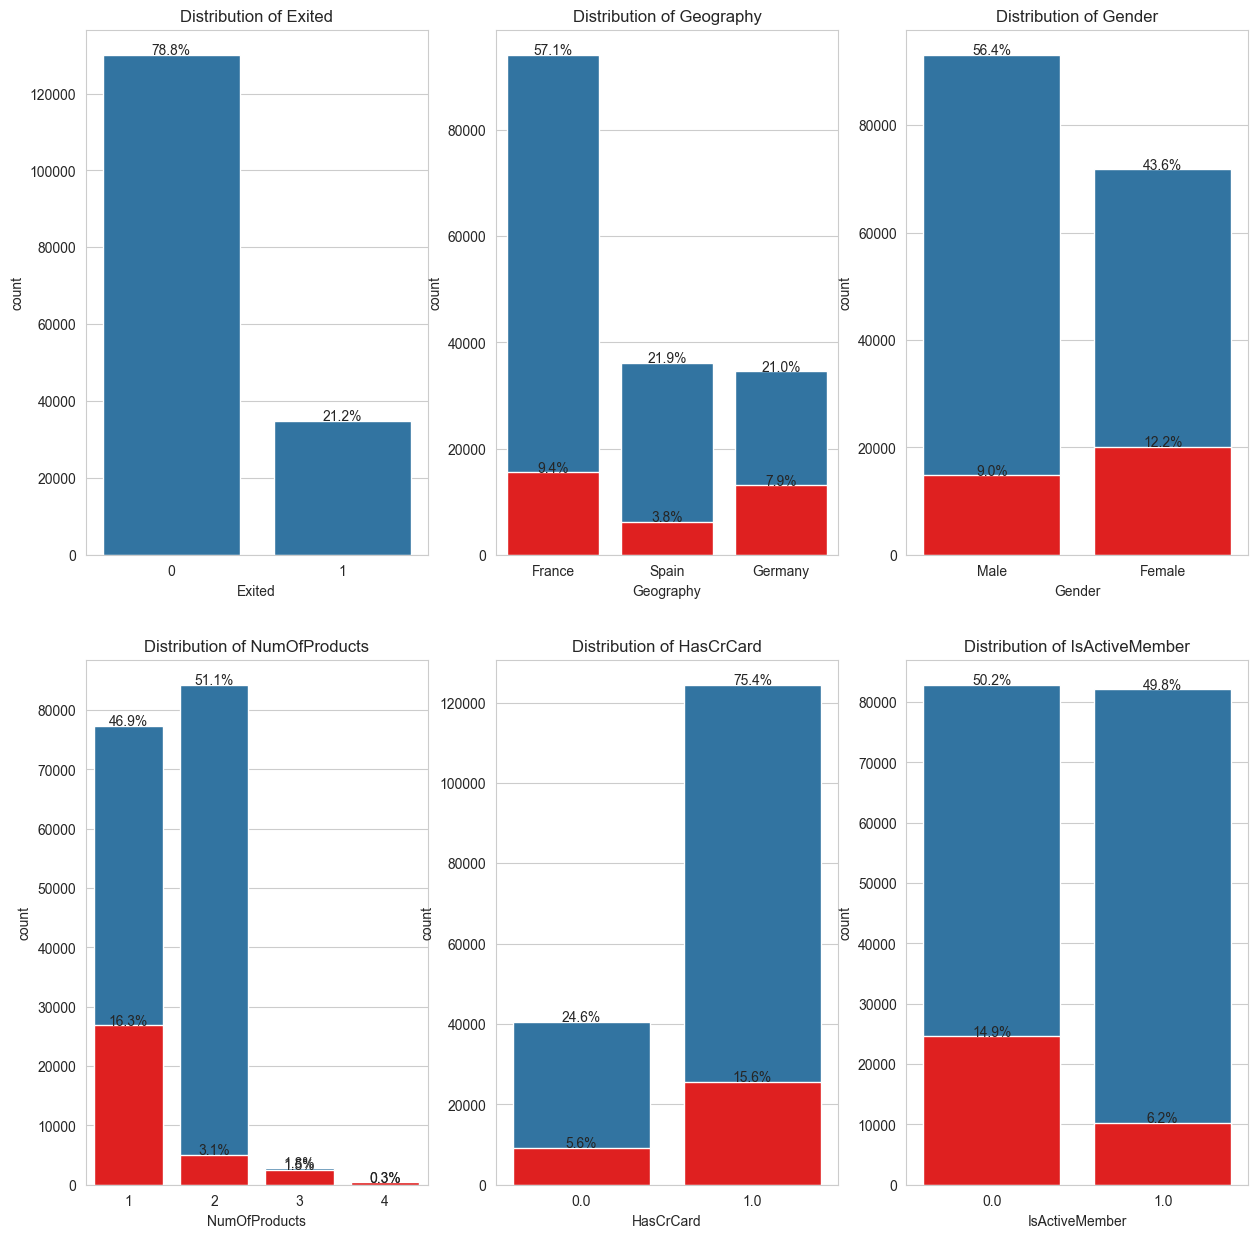

In [11]:
#plot distribution information
fig, ax= plt.subplots(2,3,figsize=(15,15))
cat_list = ['Geography','Gender','NumOfProducts','HasCrCard','IsActiveMember','Exited']
exit_table = train_df[train_df['Exited']==1]
def print_pct(ax):
    for patches in ax.patches:
            count = patches.get_height()
            pct = count/train_df.shape[0]*100
            pct = '{:.1f}%'.format(pct)
            ax.annotate(pct,xy = (patches.get_x()+patches.get_width()/2., patches.get_height()),ha = 'center',va = 'baseline')
plt.subplot(2,3,1)
ax = sns.countplot(data=train_df,x='Exited')
print_pct(ax)
plt.title('Distribution of Exited')
for i in range(len(cat_list)-1):
    plt.subplot(2,3,i+2)
    sns.set_palette('bwr')
    ax = sns.countplot(data = train_df, x=cat_list[i])
    ax = sns.countplot(data = exit_table, x=cat_list[i], color='red')
    print_pct(ax)
    plt.title(f'Distribution of {cat_list[i]}')



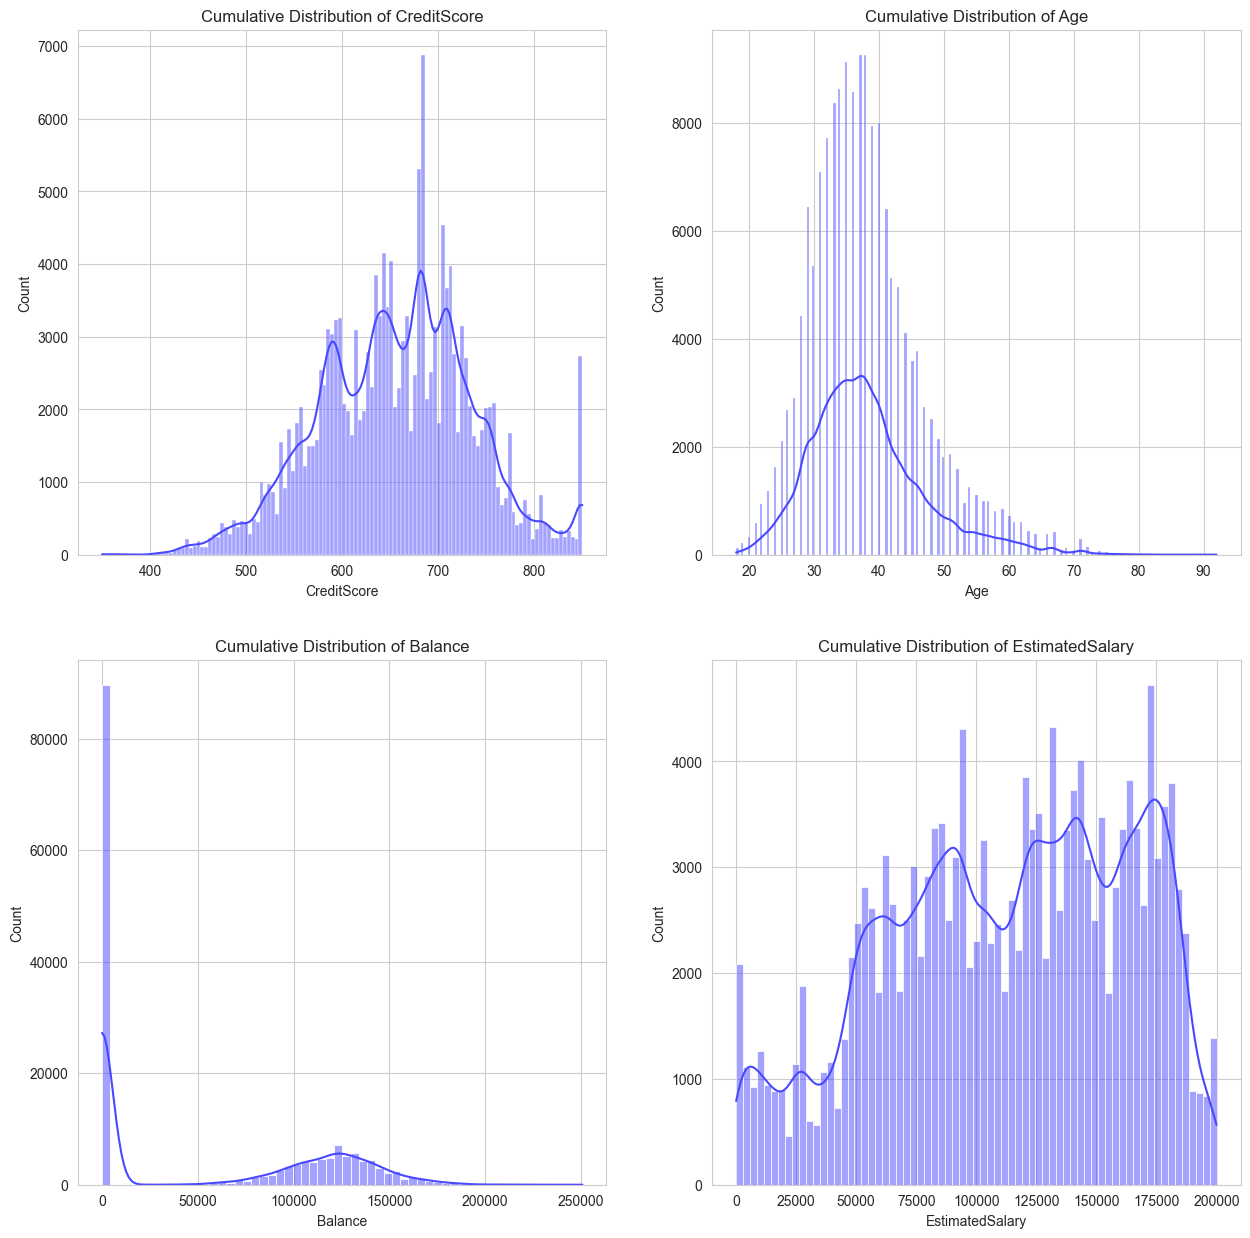

In [12]:
cumu_col = ['CreditScore','Age','Balance','EstimatedSalary']
fig, ax = plt.subplots(2,2,figsize=(15,15))
for i in range(len(cumu_col)):
    plt.subplot(2,2,i+1)
    sns.set_palette('pastel')
    sns.histplot(data=train_df,x=cumu_col[i],kde=True)
    plt.title(f'Cumulative Distribution of {cumu_col[i]}')


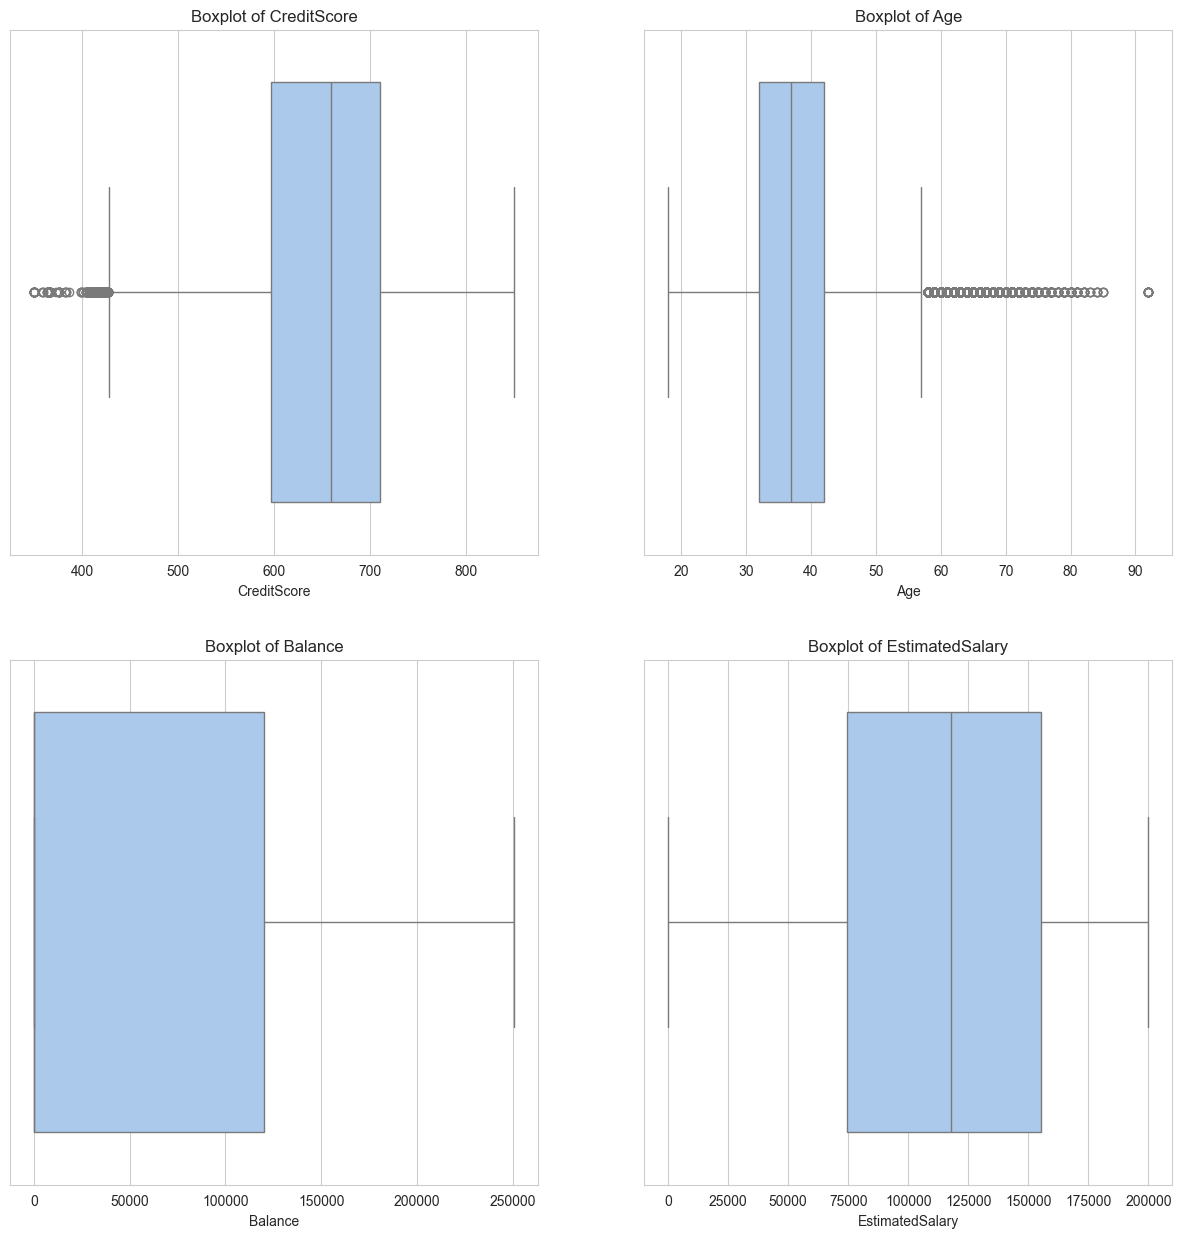

In [13]:
box_col = ['CreditScore','Age','Balance','EstimatedSalary']
fig, ax = plt.subplots(2,2,figsize=(15,15))
for i in range(len(box_col)):
    plt.subplot(2,2,i+1)
    sns.boxplot(data=train_df,x=box_col[i])
    plt.title(f'Boxplot of {box_col[i]}')

Text(0, 0.5, 'Count')

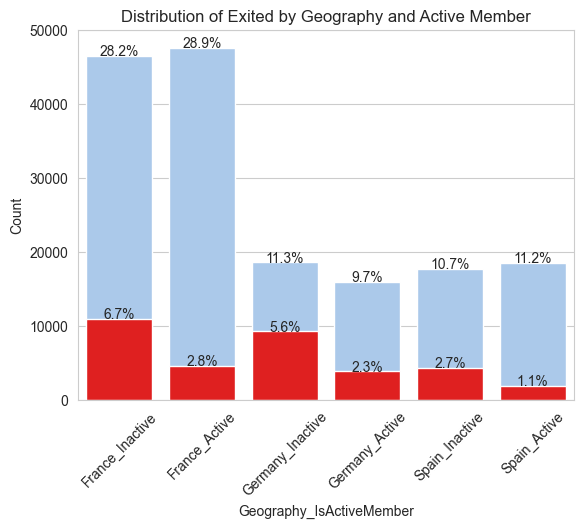

In [14]:
geoactive = pd.concat([train_df.groupby(['Geography','IsActiveMember'])['Exited'].count(),
exit_table.groupby(['Geography','IsActiveMember'])['Exited'].count()], axis=1)
geoactive = geoactive.rename(index={1:'Active',0:'Inactive'}).reset_index()
geoactive['index'] = geoactive['Geography'] + '_' + geoactive['IsActiveMember']
geoactive.set_index('index',inplace=True)
geoactive.columns = ['Geography', 'IsActiveMember', 'TotalNum', 'ExitedNum']
ax = sns.barplot(data=geoactive, x='index', y='TotalNum')
ax = sns.barplot(data=geoactive, x='index', y='ExitedNum', color='red')
print_pct(ax)
plt.xticks(rotation=45)
plt.title('Distribution of Exited by Geography and Active Member')
plt.xlabel('Geography_IsActiveMember')
plt.ylabel('Count')

In [15]:
corr_train = train_df.copy()

<Axes: >

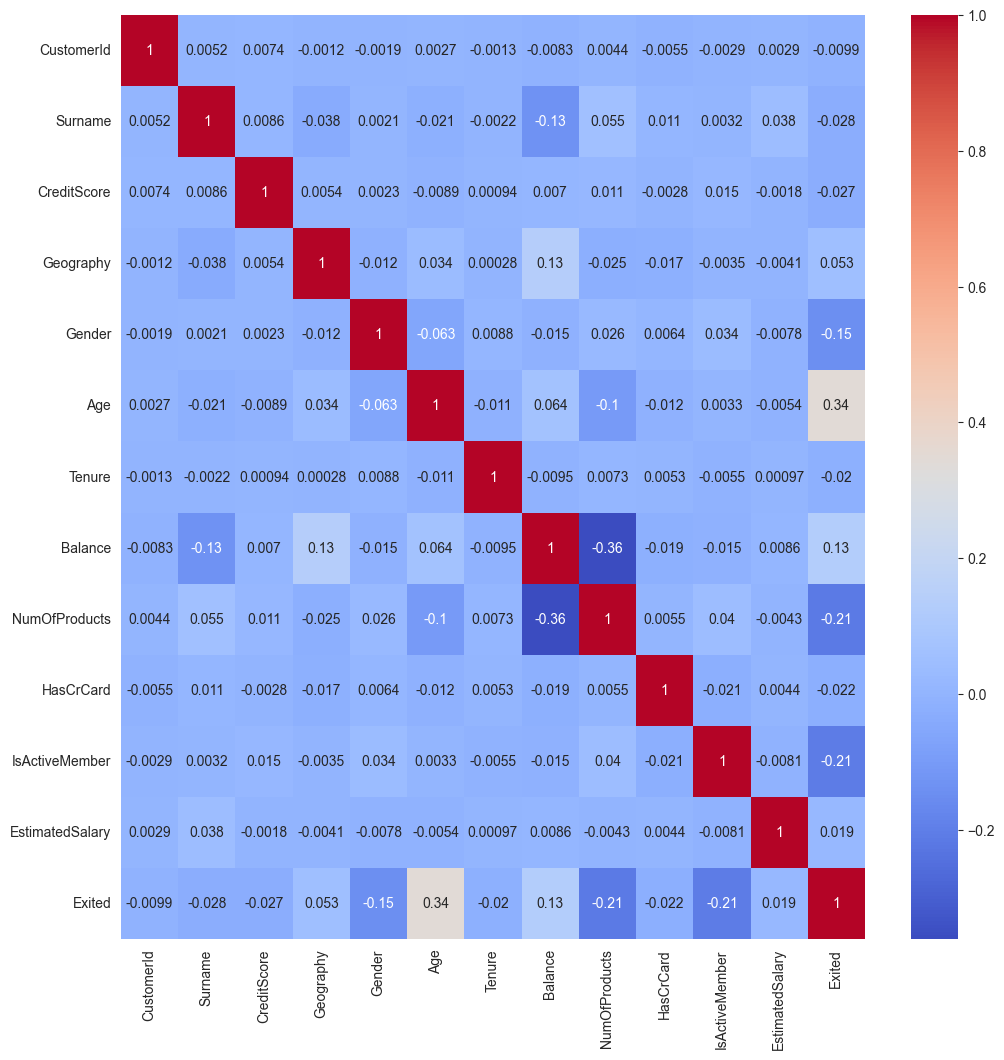

In [16]:
corr_df = [x for x in train_df.columns if train_df[x].dtype == 'object']
for i in corr_df:
    corr_train[i] = LabelEncoder().fit_transform(corr_train[i])
plt.figure(figsize=(12,12))
sns.heatmap(corr_train.corr(),annot=True, cmap='coolwarm')

In [17]:
#split X and Y
X=train_df.drop(columns = ['Exited'])
Y=train_df['Exited']

In [18]:
#apply standard scaler to numerical columns
scaler = StandardScaler()
X[box_col] = scaler.fit_transform(X[box_col])
#generate dummy variables
X = pd.get_dummies(X,columns=['Geography','Gender'],drop_first=True)

In [19]:
X1 = X.copy()
X=X.drop(columns = ['CustomerId','Surname'])
#generate joint column of id and surname
X1['idname'] = train_df['Surname']+train_df['CustomerId'].astype(str)
X1.drop(columns = ['CustomerId','Surname'])
#initialise TF-IDF
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))  
#apply to idname
Xname = vectorizer.fit_transform(X1['idname'])
#use SVD to extract 3 character
svd = TruncatedSVD(3)
x_sv_train = svd.fit_transform(Xname)
X_sv_train = pd.DataFrame(x_sv_train, columns=['Surname_svd_1', 'Surname_svd_2', 'Surname_svd_3'])
X1 = pd.concat([X, X_sv_train], axis=1)

In [20]:
#split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y, test_size=0.2)

Logistic Regression with initial data
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     26088
           1       0.69      0.38      0.49      6919

    accuracy                           0.84     33007
   macro avg       0.77      0.67      0.70     33007
weighted avg       0.82      0.84      0.82     33007



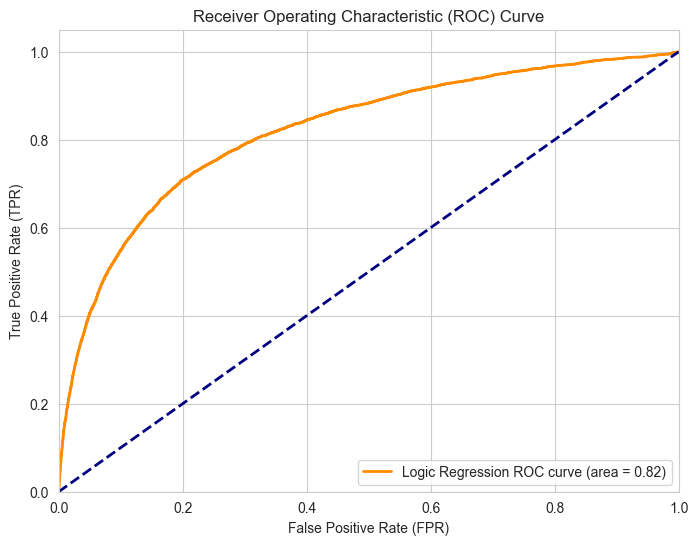

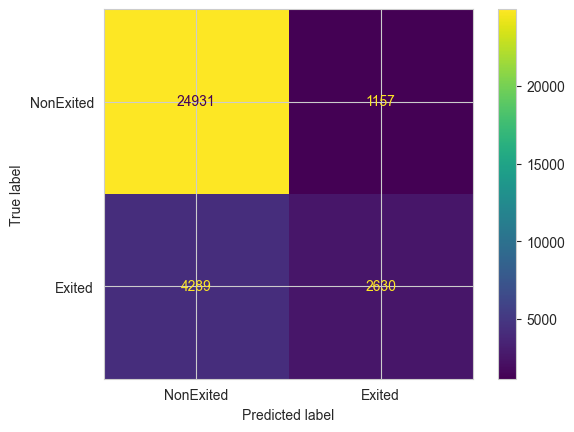

logit(Exited) = -0.06*(CreditScore)+0.83*(Age)-0.02*(Tenure)-0.12*(Balance)-0.91*(NumOfProducts)-0.16*(HasCrCard)-1.28*(IsActiveMember)+0.05*(EstimatedSalary)+1.13*(Geography_Germany)+0.02*(Geography_Spain)-0.66*(Gender_Male)+0.64

Logistic Regression with transformed data
              precision    recall  f1-score   support

           0       0.79      0.89      0.84     26088
           1       0.21      0.12      0.15      6919

    accuracy                           0.72     33007
   macro avg       0.50      0.50      0.49     33007
weighted avg       0.67      0.72      0.69     33007



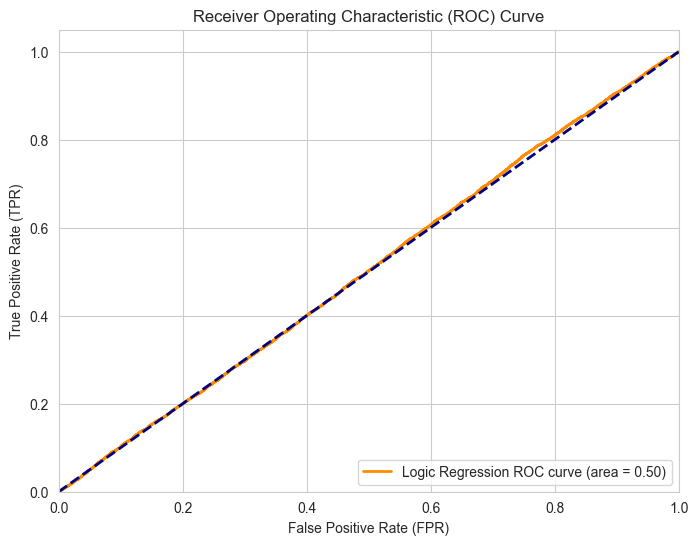

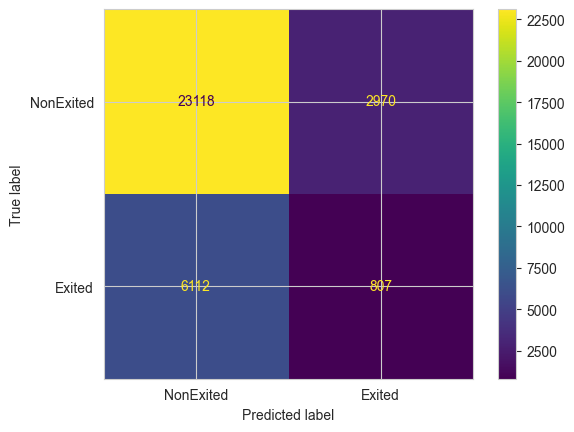

logit(Exited) = -0.06*(CreditScore)+0.83*(Age)-0.01*(Tenure)-0.12*(Balance)-0.91*(NumOfProducts)-0.15*(HasCrCard)-1.28*(IsActiveMember)+0.05*(EstimatedSalary)+1.15*(Geography_Germany)+0.05*(Geography_Spain)-0.65*(Gender_Male)-0.98*(Surname_svd_1)+0.09*(Surname_svd_2)-0.02*(Surname_svd_3)+0.85



In [21]:
#Logistic regression with initial data
#initialise the model
def Logic_Regression(X_train, y_train, X_test, description):
    model = LogisticRegression(max_iter = 10000)
    #train the model
    model.fit(X_train, y_train)
    
    #make prediction
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)
    #Evaluation
    print(description)
    print(classification_report(y_test, y_pred))
    #get roc
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    #draw ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Logic Regression ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    #draw Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['NonExited','Exited'])
    plt.show()
    # get coefficients and intercept
    coefficients = model.coef_[0] 
    intercept = model.intercept_[0]
    print(f'logit(Exited) = ',end='')
    #print coefficients based on + and -
    for i in range(len(coefficients)):
        if i == 0 and coefficients[i] >= 0:
            print(f'{coefficients[i]:.2f}*({X_train.columns[i]})',end='')
        elif coefficients[i] >= 0:
            print(f'+{coefficients[i]:.2f}*({X_train.columns[i]})',end='')
        else:
            print(f'{coefficients[i]:.2f}*({X_train.columns[i]})',end='')
    if intercept < 0:
        print(f'{intercept:.2f}\n')
    else:
        print(f'+{intercept:.2f}\n')
Logic_Regression(X_train, y_train, X_test, 'Logistic Regression with initial data')
Logic_Regression(X_train1, y_train1, X_test1, 'Logistic Regression with transformed data')

decision tree model with initial data
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     26088
           1       0.52      0.53      0.52      6919

    accuracy                           0.80     33007
   macro avg       0.70      0.70      0.70     33007
weighted avg       0.80      0.80      0.80     33007



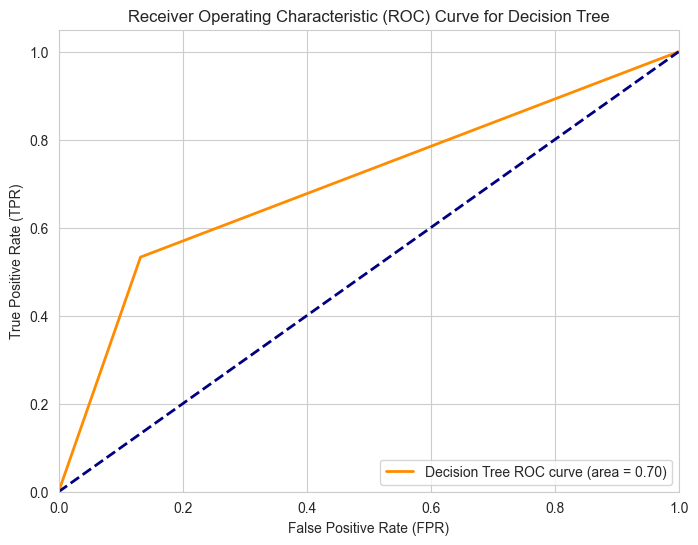

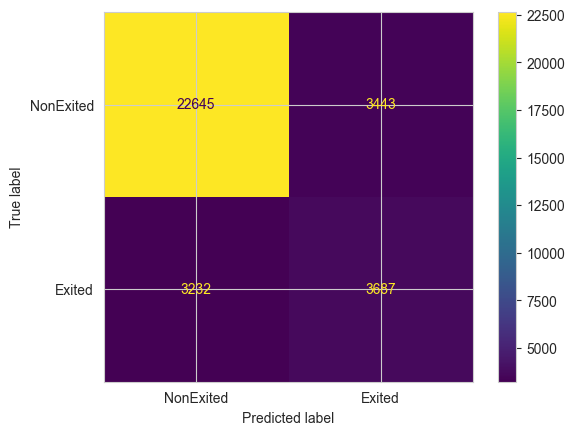

decision tree model with transformed data
              precision    recall  f1-score   support

           0       0.79      0.78      0.78     26088
           1       0.21      0.22      0.21      6919

    accuracy                           0.66     33007
   macro avg       0.50      0.50      0.50     33007
weighted avg       0.67      0.66      0.66     33007



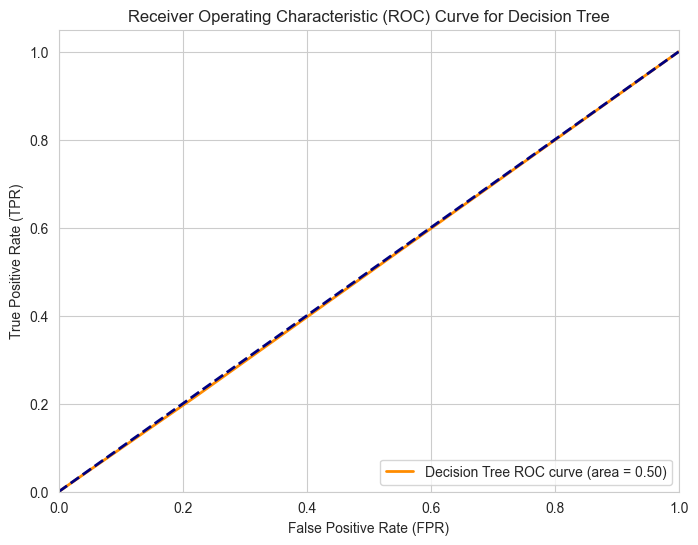

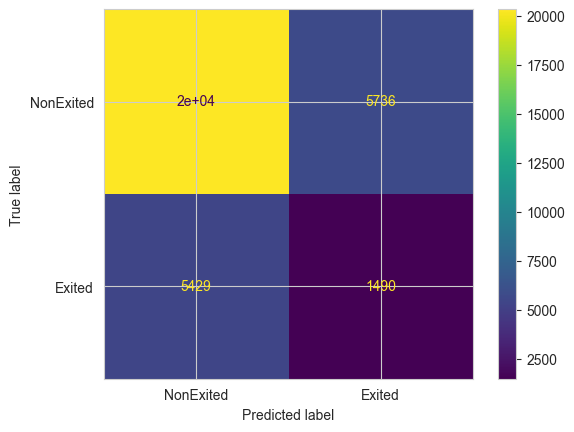

In [22]:
#decision tree
def decision_tree_model(X_train, y_train, X_test, description):
    #initialise the model
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    #make prediction
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)
    print(description)
    print(classification_report(y_test, y_pred))

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Decision Tree ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
    plt.legend(loc="lower right")
    plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['NonExited','Exited'])
    plt.show()
decision_tree_model(X_train, y_train,X_test,'decision tree model with initial data')
decision_tree_model(X_train1, y_train1,X_test1,'decision tree model with transformed data')

polynomial logistic regression with initial data
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     26088
           1       0.74      0.52      0.61      6919

    accuracy                           0.86     33007
   macro avg       0.81      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007



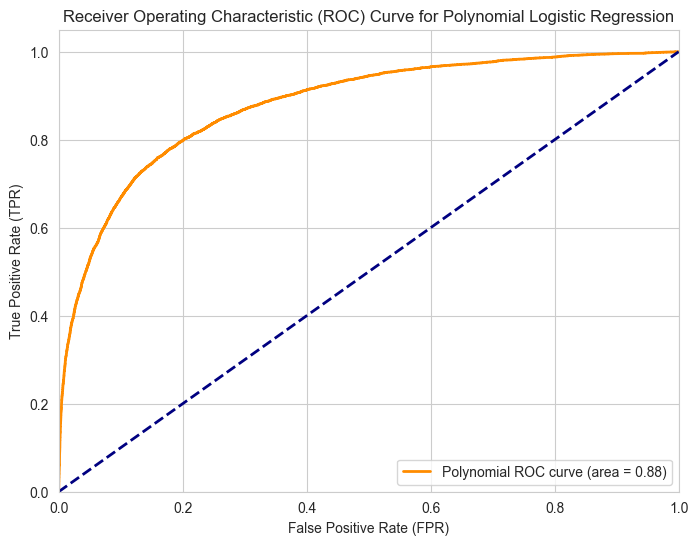

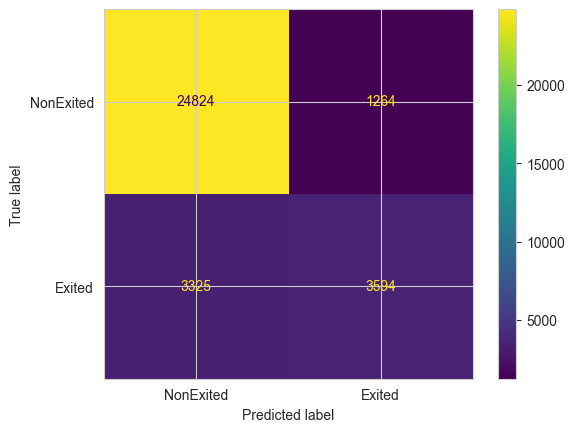

polynomial logistic regression with transformed data
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     26088
           1       0.21      0.15      0.18      6919

    accuracy                           0.71     33007
   macro avg       0.50      0.50      0.50     33007
weighted avg       0.67      0.71      0.69     33007



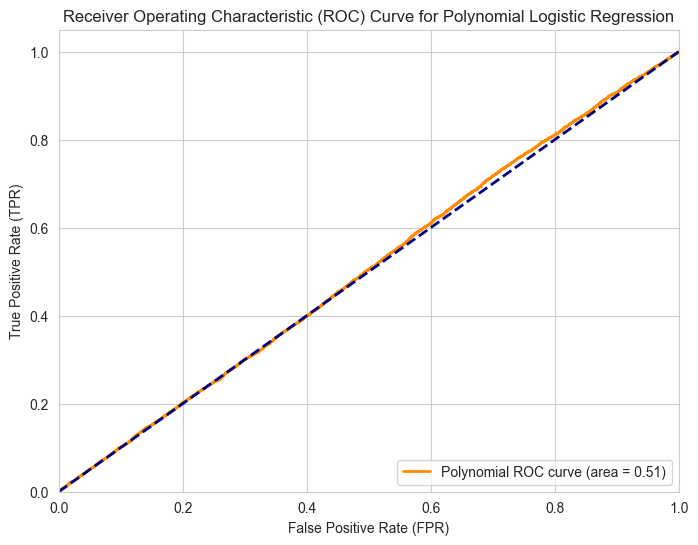

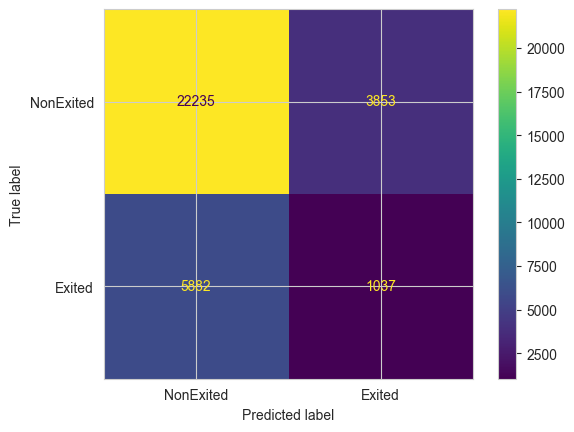

In [23]:
def polynomial_logistic_regression(X_train, y_train, X_test, description):
    #initialize the features
    poly = PolynomialFeatures(degree=2, include_bias=False)

    #construct the model
    model = LogisticRegression(max_iter=10000)

    #set up the pipeline
    pipeline = Pipeline([
        ('poly', poly),
        ('logreg', model)
    ])

    pipeline.fit(X_train, y_train)

    y_prob = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)
    print(description)
    print(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Polynomial ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Polynomial Logistic Regression')
    plt.legend(loc="lower right")
    plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['NonExited','Exited'])
    plt.show()
polynomial_logistic_regression(X_train, y_train,X_test,'polynomial logistic regression with initial data')
polynomial_logistic_regression(X_train1, y_train1,X_test1,'polynomial logistic regression with transformed data')

KNN with initial data
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     26088
           1       0.67      0.53      0.59      6919

    accuracy                           0.85     33007
   macro avg       0.78      0.73      0.75     33007
weighted avg       0.84      0.85      0.84     33007



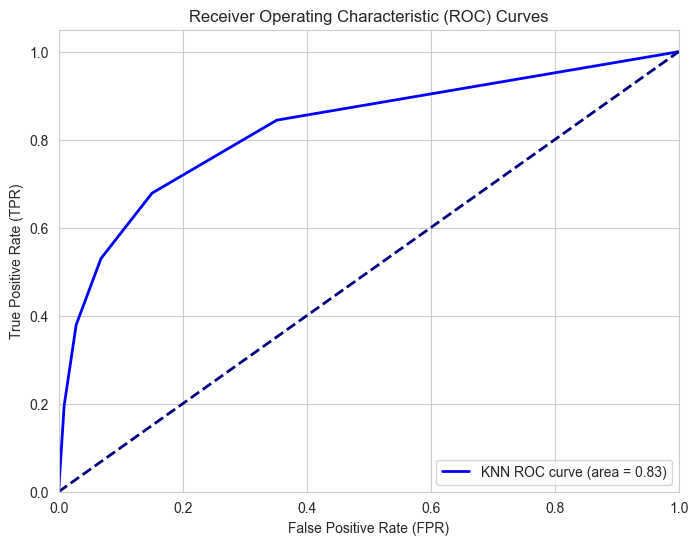

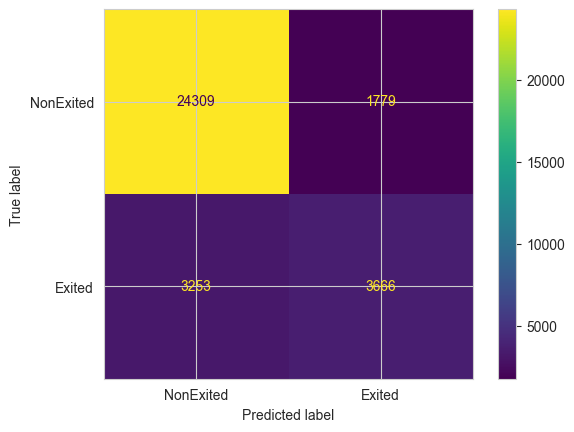

KNN with transformed data
              precision    recall  f1-score   support

           0       0.79      0.84      0.81     26088
           1       0.21      0.17      0.19      6919

    accuracy                           0.70     33007
   macro avg       0.50      0.50      0.50     33007
weighted avg       0.67      0.70      0.68     33007



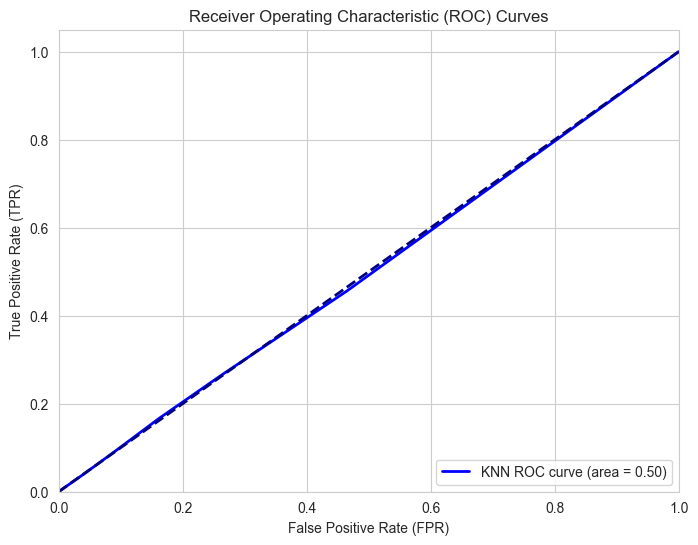

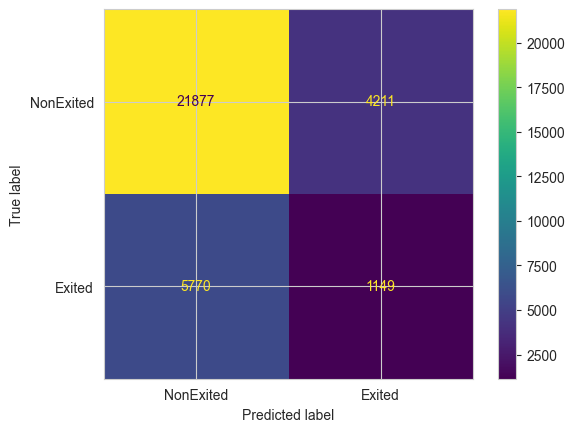

In [24]:
def knn_model(X_train, y_train, X_test, description):
    #initialize the scaler
    scaler = StandardScaler()

    #apply the scaler
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #construct the model
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train_scaled, y_train)

    #make prediction
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)

    #Evaluation
    print(description)
    print(classification_report(y_test, y_pred))
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob)

    roc_auc_knn = auc(fpr_knn, tpr_knn)

    plt.figure(figsize=(8, 6))

    plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN ROC curve (area = {roc_auc_knn:.2f})')


    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['NonExited','Exited'])
    plt.show()
knn_model(X_train, y_train,X_test,'KNN with initial data')
knn_model(X_train1, y_train1,X_test1,'KNN with transformed data')

Random Forest with initial data
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     26088
           1       0.73      0.51      0.60      6919

    accuracy                           0.86     33007
   macro avg       0.80      0.73      0.76     33007
weighted avg       0.85      0.86      0.85     33007



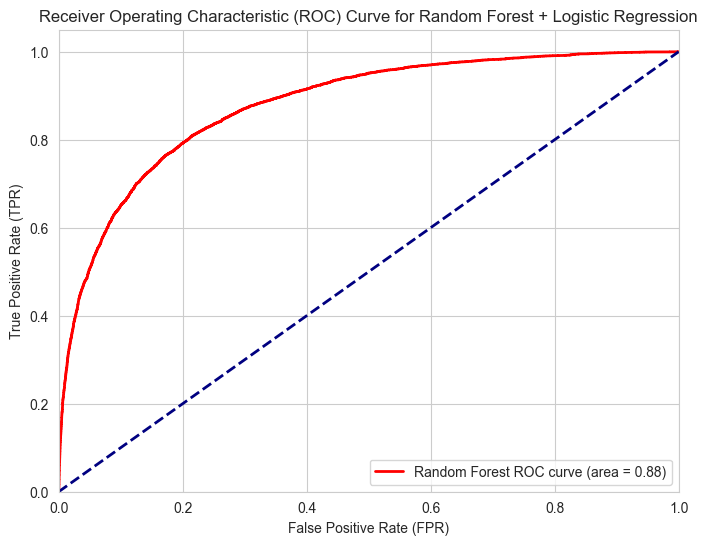

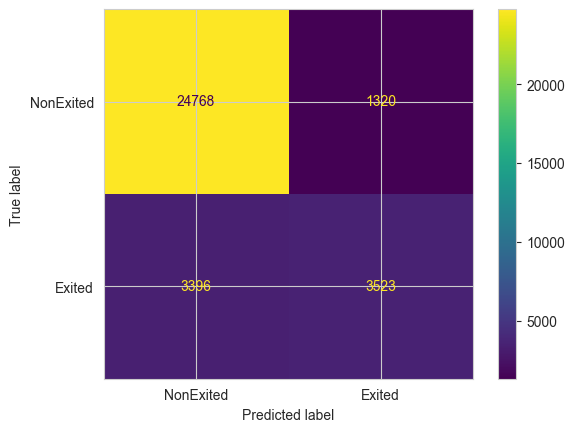

Random Forest with transformed data
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     26043
           1       0.71      0.50      0.59      6964

    accuracy                           0.85     33007
   macro avg       0.79      0.72      0.75     33007
weighted avg       0.84      0.85      0.84     33007



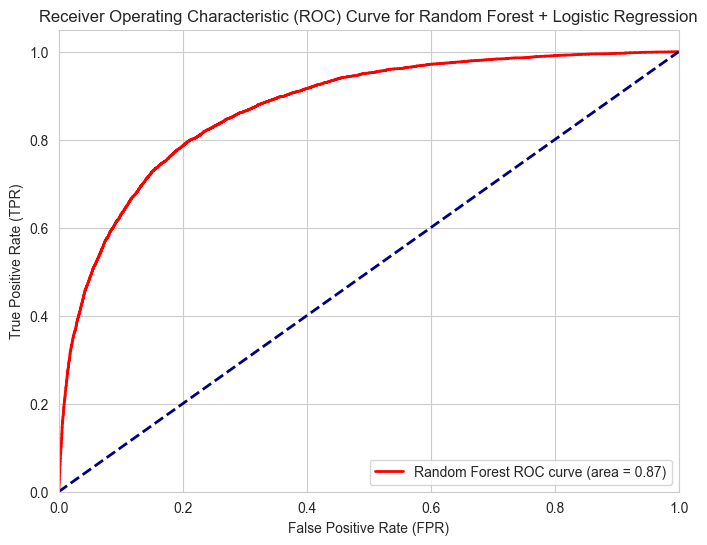

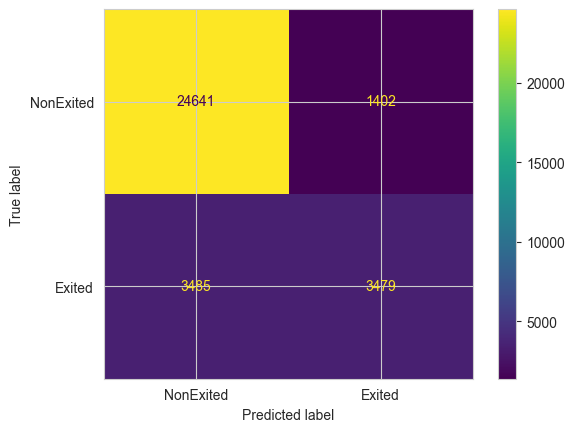

In [25]:
def random_forest_model(X_train, y_train, X_test, description, y_test):
    # Initialize Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Transform both train and test data using the fitted Random Forest model
    X_train_rf = rf.apply(X_train)
    X_test_rf = rf.apply(X_test)

    # Train Logistic Regression on transformed features
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train_rf, y_train)

    # Make predictions
    y_prob = model.predict_proba(X_test_rf)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)

    # Skip evaluation if this is a test dataset
    
    print(description)
    print(classification_report(y_test, y_pred))

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc_logreg = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'Random Forest ROC curve (area = {roc_auc_logreg:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest + Logistic Regression')
    plt.legend(loc="lower right")
    plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['NonExited','Exited'])
    plt.show()
# Training and evaluating with initial data
random_forest_model(X_train, y_train, X_test, 'Random Forest with initial data', y_test=y_test)
y_pred_rf = random_forest_model(X_train1, y_train1, X_test1, 'Random Forest with transformed data', y_test=y_test1)

XGboost with initial data
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26088
           1       0.75      0.53      0.62      6919

    accuracy                           0.86     33007
   macro avg       0.82      0.74      0.77     33007
weighted avg       0.86      0.86      0.86     33007



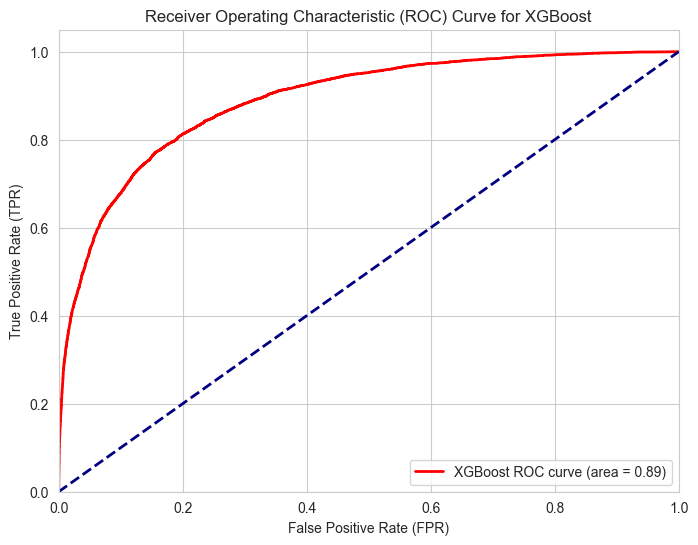

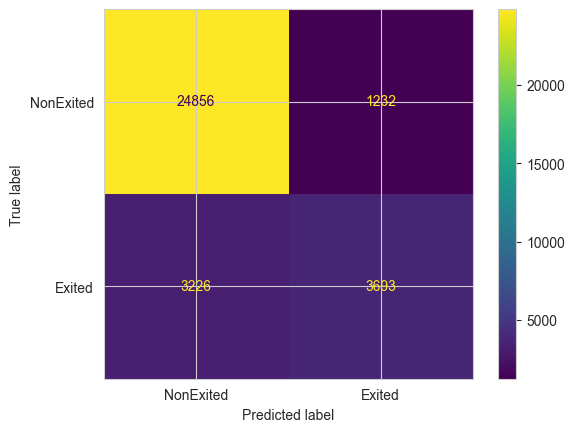

XGboost with transformed data
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     26088
           1       0.21      0.15      0.18      6919

    accuracy                           0.70     33007
   macro avg       0.50      0.50      0.50     33007
weighted avg       0.67      0.70      0.69     33007



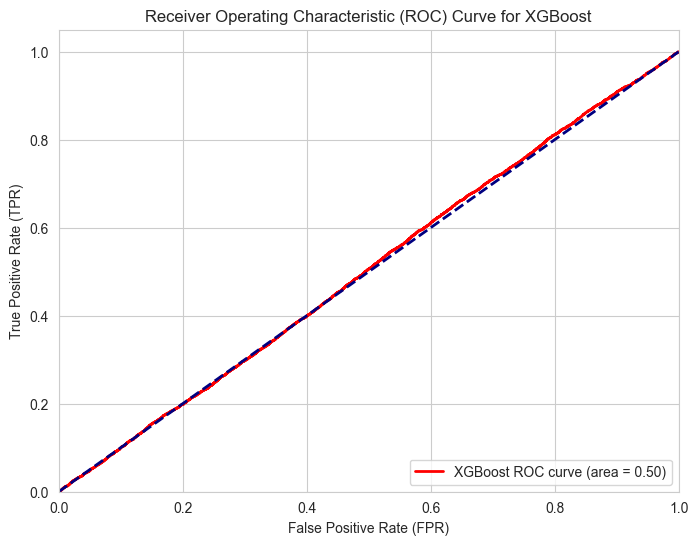

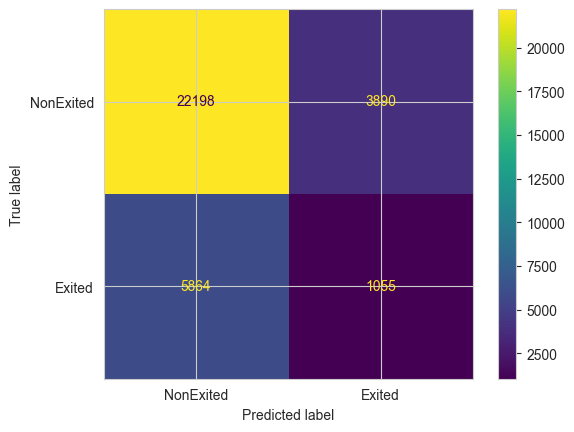

In [26]:
def xgboost_model(X_train, y_train, X_test, description):
#prepare the data
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    #set params
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.1,
        'max_depth': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }
    num_rounds = 100

    #construct the model
    model = xgb.train(params, dtrain, num_rounds)
    y_prob = model.predict(dtest)

    #make prediction
    y_pred = (y_prob > 0.5).astype(int)

    #Evaluation
    print(description)
    print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_prob)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'XGBoost ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
    plt.legend(loc="lower right")
    plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['NonExited','Exited'])
    plt.show()
xgboost_model(X_train, y_train, X_test,'XGboost with initial data')
xgboost_model(X_train1, y_train1, X_test1,'XGboost with transformed data')

Catboost with initial data
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26088
           1       0.75      0.53      0.62      6919

    accuracy                           0.86     33007
   macro avg       0.82      0.74      0.77     33007
weighted avg       0.86      0.86      0.86     33007



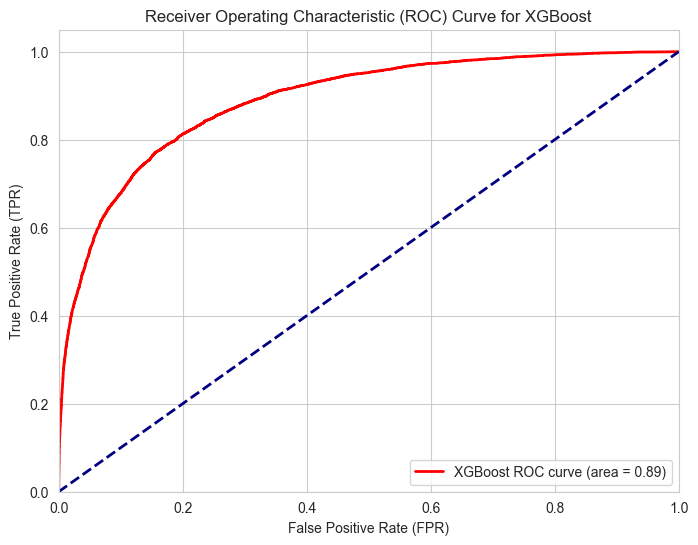

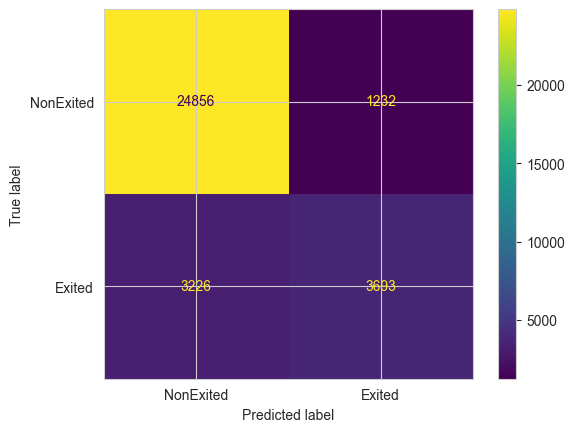

Catboost with transformed data
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     26088
           1       0.21      0.15      0.18      6919

    accuracy                           0.70     33007
   macro avg       0.50      0.50      0.50     33007
weighted avg       0.67      0.70      0.69     33007



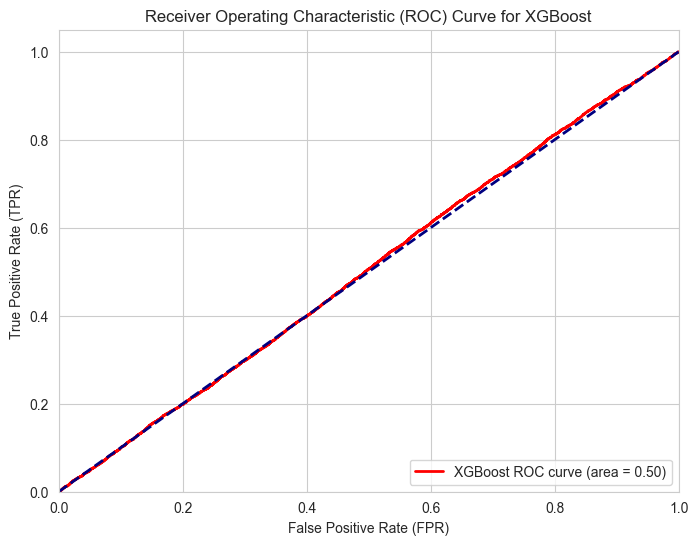

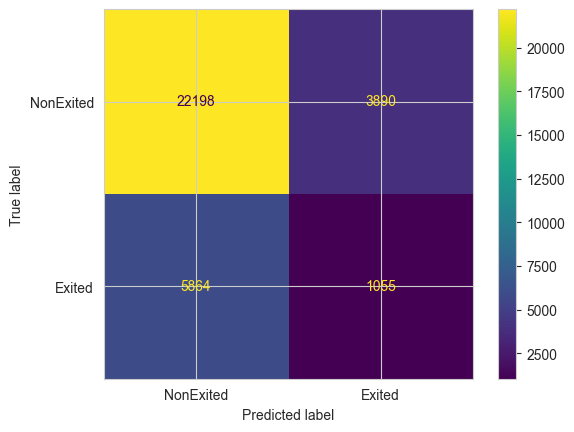

In [27]:
def catboost_model(X_train, y_train, X_test, description):
    model = CatBoostClassifier(
    iterations=100,  # 训练轮数
    learning_rate=0.1,  # 学习率
    depth=6,  # 树的深度
    verbose=20  # 每 20 轮输出一次日志
)

# 训练模型
    model.fit(X_train, y_train)


    #make prediction
    y_pred = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred > 0.5).astype(int)

    #Evaluation
    print(description)
    print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_pred)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'CatBoost ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
    plt.legend(loc="lower right")
    plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['NonExited','Exited'])
    plt.show()
xgboost_model(X_train, y_train, X_test,'Catboost with initial data')
xgboost_model(X_train1, y_train1, X_test1,'Catboost with transformed data')

In [28]:
def rf_optimise(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


best_rf_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
best_rf_study.optimize(rf_optimise, n_trials=50)

print("Best trial:")
trial = best_rf_study.best_trial
print("  Accuracy Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print(f"Best Accuracy: {best_rf_study.best_value}")

[I 2024-12-01 20:02:23,989] A new study created in memory with name: no-name-b6b857cf-3f6e-44ad-9ea0-f9faf740d937
[I 2024-12-01 20:02:27,575] Trial 0 finished with value: 0.841094313327476 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.841094313327476.
[I 2024-12-01 20:02:28,581] Trial 1 finished with value: 0.7911352137425395 and parameters: {'n_estimators': 162, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.841094313327476.
[I 2024-12-01 20:02:32,432] Trial 2 finished with value: 0.8335504589935469 and parameters: {'n_estimators': 341, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.841094313327476.
[I 2024-12-01 20:02:35,148] Trial 3 finished with value: 0.8006483473202654 and parameters: {'n_estimators': 433, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.

Best trial:
  Accuracy Value:  0.8556669797315721
  Params: 
    n_estimators: 457
    max_depth: 20
    min_samples_split: 3
    min_samples_leaf: 2
Best Accuracy: 0.8556669797315721


Classification Report after Optimisation
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     26088
           1       0.66      0.64      0.65      6919

    accuracy                           0.86     33007
   macro avg       0.78      0.78      0.78     33007
weighted avg       0.85      0.86      0.85     33007



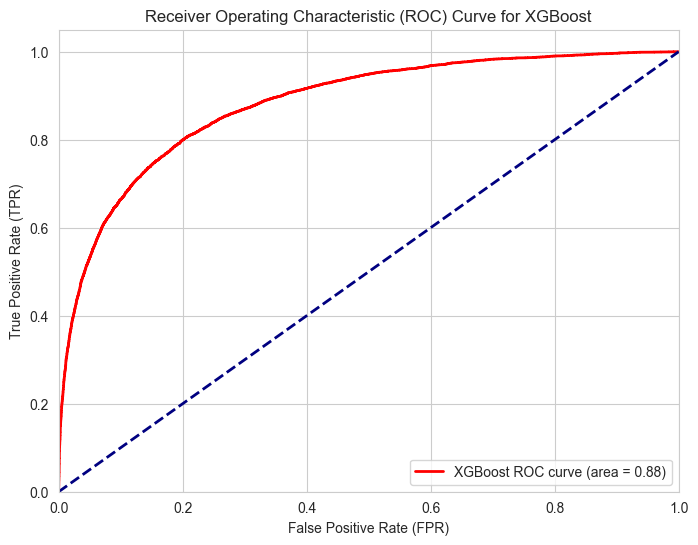

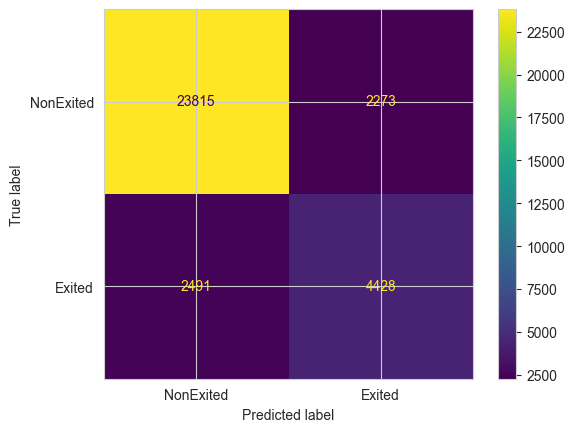

In [38]:
best_params = best_rf_study.best_params
best_rf_model = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42, n_jobs=-1)
best_rf_model.fit(X_train, y_train)
y_prob1 = best_rf_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob1 > 0.5).astype(int)
print('Classification Report after Optimisation')
print(classification_report(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_prob1)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'XGBoost ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['NonExited','Exited'])
plt.show()

In [31]:
def xgb_optimise(trial):
    # define the range of parameters
    print(type(trial))
    param = {
        'booster': 'gbtree',
        'tree_method': 'auto',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-3, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # get the accuracy
    model = XGBClassifier(**param, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)
    auccuracy = accuracy_score(y_test, y_pred)
    return auccuracy


# optimisation with optuna
best_xgb_study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
best_xgb_study.optimize(xgb_optimise, n_trials=50) 

# get the best parameters and value
trial = best_xgb_study.best_trial
print(" Accuracy  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-12-01 20:06:50,167] A new study created in memory with name: no-name-684c8a88-357a-4f7a-b8f9-d802c0c10674


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:50,605] Trial 0 finished with value: 0.8648165540642894 and parameters: {'lambda': 3.7460266483547775, 'alpha': 9.507192349792751, 'learning_rate': 0.7320207424172239, 'n_estimators': 319, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.5817780380698264, 'subsample': 0.9330880728874675, 'colsample_bytree': 0.8005575058716043}. Best is trial 0 with value: 0.8648165540642894.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:51,310] Trial 1 finished with value: 0.8577877419941224 and parameters: {'lambda': 7.08101770538266, 'alpha': 0.20682435846372868, 'learning_rate': 0.9699128611767781, 'n_estimators': 425, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 1.8348616940244846, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119}. Best is trial 0 with value: 0.8648165540642894.
[I 2024-12-01 20:06:51,431] Trial 2 finished with value: 0.8656345623655588 and parameters: {'lambda': 4.320018241402516, 'alpha': 2.913000172840221, 'learning_rate': 0.6118917094329073, 'n_estimators': 112, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 4.561243772186143, 'subsample': 0.8925879806965068, 'colsample_bytree': 0.5998368910791798}. Best is trial 2 with value: 0.8656345623655588.


<class 'optuna.trial._trial.Trial'>
<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:51,830] Trial 3 finished with value: 0.8654527827430545 and parameters: {'lambda': 5.142830149697703, 'alpha': 5.924553274051563, 'learning_rate': 0.04654576767872573, 'n_estimators': 324, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 9.488906486996079, 'subsample': 0.9828160165372797, 'colsample_bytree': 0.9041986740582306}. Best is trial 2 with value: 0.8656345623655588.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:52,152] Trial 4 finished with value: 0.8657860453843124 and parameters: {'lambda': 3.0468330779645334, 'alpha': 0.9776234679498323, 'learning_rate': 0.6842646032095057, 'n_estimators': 248, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.34485082263106875, 'subsample': 0.954660201039391, 'colsample_bytree': 0.6293899908000085}. Best is trial 4 with value: 0.8657860453843124.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:52,365] Trial 5 finished with value: 0.8653921895355531 and parameters: {'lambda': 6.625560321255467, 'alpha': 3.11779904981802, 'learning_rate': 0.520116014375693, 'n_estimators': 296, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 7.751553100787786, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245}. Best is trial 4 with value: 0.8657860453843124.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:52,609] Trial 6 finished with value: 0.8654224861393038 and parameters: {'lambda': 5.979401888132041, 'alpha': 9.218820475996145, 'learning_rate': 0.0885836528017143, 'n_estimators': 138, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 3.887384219605131, 'subsample': 0.6356745158869479, 'colsample_bytree': 0.9143687545759647}. Best is trial 4 with value: 0.8657860453843124.
[I 2024-12-01 20:06:52,729] Trial 7 finished with value: 0.8649377404792923 and parameters: {'lambda': 3.5681765136091994, 'alpha': 2.8100641623641205, 'learning_rate': 0.5427418135499327, 'n_estimators': 113, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 9.868882479068573, 'subsample': 0.8861223846483287, 'colsample_bytree': 0.5993578407670862}. Best is trial 4 with value: 0.8657860453843124.


<class 'optuna.trial._trial.Trial'>
<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:53,217] Trial 8 finished with value: 0.8643015118005272 and parameters: {'lambda': 0.056215649118900396, 'alpha': 8.154798823119886, 'learning_rate': 0.7068866581132324, 'n_estimators': 378, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 3.5852988197141817, 'subsample': 0.5579345297625649, 'colsample_bytree': 0.9315517129377968}. Best is trial 4 with value: 0.8657860453843124.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:53,520] Trial 9 finished with value: 0.8653618929318023 and parameters: {'lambda': 6.233357970148752, 'alpha': 3.309649350501639, 'learning_rate': 0.06365199445099504, 'n_estimators': 190, 'max_depth': 5, 'min_child_weight': 8, 'gamma': 6.375937156080776, 'subsample': 0.9436063712881633, 'colsample_bytree': 0.7361074625809747}. Best is trial 4 with value: 0.8657860453843124.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:54,131] Trial 10 finished with value: 0.8630896476504983 and parameters: {'lambda': 9.451420305759637, 'alpha': 0.06096583237521447, 'learning_rate': 0.30776344202911743, 'n_estimators': 220, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 0.1522530323179326, 'subsample': 0.8067811097520365, 'colsample_bytree': 0.5236962177512632}. Best is trial 4 with value: 0.8657860453843124.
[I 2024-12-01 20:06:54,261] Trial 11 finished with value: 0.8641803253855243 and parameters: {'lambda': 1.7637526419466782, 'alpha': 1.7036786118659673, 'learning_rate': 0.7757407994516055, 'n_estimators': 59, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 2.4014257648033968, 'subsample': 0.8379286425350437, 'colsample_bytree': 0.6369622551925751}. Best is trial 4 with value: 0.8657860453843124.


<class 'optuna.trial._trial.Trial'>
<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:54,512] Trial 12 finished with value: 0.8650892234980458 and parameters: {'lambda': 2.9782947044916943, 'alpha': 5.182073497477522, 'learning_rate': 0.335904641130416, 'n_estimators': 232, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 5.768636925205972, 'subsample': 0.7550303757540241, 'colsample_bytree': 0.6489222752042844}. Best is trial 4 with value: 0.8657860453843124.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:54,894] Trial 13 finished with value: 0.8639379525555185 and parameters: {'lambda': 1.6508885103579087, 'alpha': 1.6299270346906085, 'learning_rate': 0.9292906238655247, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 4.498761180358644, 'subsample': 0.8737138365352108, 'colsample_bytree': 0.5186515887970377}. Best is trial 4 with value: 0.8657860453843124.
[I 2024-12-01 20:06:55,028] Trial 14 finished with value: 0.8654527827430545 and parameters: {'lambda': 8.342072311697072, 'alpha': 4.006006446630719, 'learning_rate': 0.6215790350354479, 'n_estimators': 54, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 1.9262087228645028, 'subsample': 0.7508714619511099, 'colsample_bytree': 0.6927094237214915}. Best is trial 4 with value: 0.8657860453843124.


<class 'optuna.trial._trial.Trial'>
<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:55,179] Trial 15 finished with value: 0.8649983336867937 and parameters: {'lambda': 4.693530318959763, 'alpha': 1.825472118003992, 'learning_rate': 0.40170756103569893, 'n_estimators': 148, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 7.335252623032323, 'subsample': 0.9992037309424531, 'colsample_bytree': 0.5785203114817359}. Best is trial 4 with value: 0.8657860453843124.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:55,398] Trial 16 finished with value: 0.8649074438755415 and parameters: {'lambda': 2.2164122309827925, 'alpha': 6.395045194242507, 'learning_rate': 0.8395553155557793, 'n_estimators': 255, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 3.0976980963874445, 'subsample': 0.8877789764799628, 'colsample_bytree': 0.8332678196538595}. Best is trial 4 with value: 0.8657860453843124.
[I 2024-12-01 20:06:55,583] Trial 17 finished with value: 0.8639076559517678 and parameters: {'lambda': 0.3542170248906764, 'alpha': 0.9853615538936769, 'learning_rate': 0.6268125572188106, 'n_estimators': 170, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 5.41921620182425, 'subsample': 0.7973712123451168, 'colsample_bytree': 0.6797711477500259}. Best is trial 4 with value: 0.8657860453843124.


<class 'optuna.trial._trial.Trial'>
<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:55,809] Trial 18 finished with value: 0.8659981216105674 and parameters: {'lambda': 4.914411200930397, 'alpha': 3.857607888298852, 'learning_rate': 0.2044365276657259, 'n_estimators': 99, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 1.1081234063623806, 'subsample': 0.9078649186547714, 'colsample_bytree': 0.5821983688049928}. Best is trial 18 with value: 0.8659981216105674.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:56,484] Trial 19 finished with value: 0.8658769351955645 and parameters: {'lambda': 7.975181006613234, 'alpha': 4.412406495337346, 'learning_rate': 0.20144348456079053, 'n_estimators': 372, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 1.0822620858020504, 'subsample': 0.7090770411410371, 'colsample_bytree': 0.5535409279713595}. Best is trial 18 with value: 0.8659981216105674.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:57,185] Trial 20 finished with value: 0.8664222740630775 and parameters: {'lambda': 7.918582051531399, 'alpha': 6.873707782467736, 'learning_rate': 0.2014232033938881, 'n_estimators': 379, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 1.3885606243665558, 'subsample': 0.6812469497890213, 'colsample_bytree': 0.5501296580653904}. Best is trial 20 with value: 0.8664222740630775.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:58,297] Trial 21 finished with value: 0.8659981216105674 and parameters: {'lambda': 7.820105576014794, 'alpha': 7.319437510886026, 'learning_rate': 0.19295569614561525, 'n_estimators': 382, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.8994801080259032, 'subsample': 0.6717986951649523, 'colsample_bytree': 0.5586030208855174}. Best is trial 20 with value: 0.8664222740630775.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:59,222] Trial 22 finished with value: 0.8648771472717909 and parameters: {'lambda': 9.630614579351569, 'alpha': 6.961065794286937, 'learning_rate': 0.20061937089317983, 'n_estimators': 431, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 1.1204303232121442, 'subsample': 0.6299909372082423, 'colsample_bytree': 0.5126381273365496}. Best is trial 20 with value: 0.8664222740630775.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:06:59,741] Trial 23 finished with value: 0.8664525706668282 and parameters: {'lambda': 8.29497662085766, 'alpha': 7.521653081914178, 'learning_rate': 0.1912619726111392, 'n_estimators': 372, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 2.6051654312702546, 'subsample': 0.6955044763827037, 'colsample_bytree': 0.5560562751462708}. Best is trial 23 with value: 0.8664525706668282.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:00,323] Trial 24 finished with value: 0.8651498167055474 and parameters: {'lambda': 8.598226192881084, 'alpha': 8.254220422289535, 'learning_rate': 0.3951455953142513, 'n_estimators': 465, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 2.7120275214578573, 'subsample': 0.582244022376492, 'colsample_bytree': 0.6971796281834504}. Best is trial 23 with value: 0.8664525706668282.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:01,030] Trial 25 finished with value: 0.865937528403066 and parameters: {'lambda': 5.314901241917955, 'alpha': 5.274707837697156, 'learning_rate': 0.15304953030450655, 'n_estimators': 348, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 1.7487643205207917, 'subsample': 0.5104964083388499, 'colsample_bytree': 0.5007177562671103}. Best is trial 23 with value: 0.8664525706668282.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:01,396] Trial 26 finished with value: 0.865513375950556 and parameters: {'lambda': 7.282197455653013, 'alpha': 8.235191765680929, 'learning_rate': 0.28577139160422194, 'n_estimators': 284, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 2.917372584502369, 'subsample': 0.7095265268049031, 'colsample_bytree': 0.5572971924483419}. Best is trial 23 with value: 0.8664525706668282.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:02,712] Trial 27 finished with value: 0.8633623170842548 and parameters: {'lambda': 9.097371729217969, 'alpha': 6.207109630541331, 'learning_rate': 0.008329614658352608, 'n_estimators': 412, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 1.4597833703799816, 'subsample': 0.6986933461709088, 'colsample_bytree': 0.5990020466188343}. Best is trial 23 with value: 0.8664525706668282.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:03,446] Trial 28 finished with value: 0.8665737570818312 and parameters: {'lambda': 5.417449389277429, 'alpha': 7.6816856042964075, 'learning_rate': 0.12640302664361225, 'n_estimators': 468, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 2.2682062047829934, 'subsample': 0.5885350136691122, 'colsample_bytree': 0.6615632424260562}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:04,051] Trial 29 finished with value: 0.8649074438755415 and parameters: {'lambda': 5.873756154361249, 'alpha': 9.754628503817068, 'learning_rate': 0.4586856194036062, 'n_estimators': 479, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 2.259718002469051, 'subsample': 0.6090110474465836, 'colsample_bytree': 0.8001205823756931}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:04,562] Trial 30 finished with value: 0.8657557487805617 and parameters: {'lambda': 8.845498854064402, 'alpha': 8.975201080940153, 'learning_rate': 0.14280826790102172, 'n_estimators': 446, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 3.9148334164379595, 'subsample': 0.5426061409569563, 'colsample_bytree': 0.7384033186874138}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:05,829] Trial 31 finished with value: 0.8611506650104523 and parameters: {'lambda': 7.303739359798373, 'alpha': 7.385380863784892, 'learning_rate': 0.2553187031257635, 'n_estimators': 322, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.03234367612331046, 'subsample': 0.6724866286056556, 'colsample_bytree': 0.6576563237392994}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:06,575] Trial 32 finished with value: 0.8662404944405732 and parameters: {'lambda': 9.922453145712849, 'alpha': 7.006987000807897, 'learning_rate': 0.11824590876545489, 'n_estimators': 409, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 1.4443412394946784, 'subsample': 0.7336431177754578, 'colsample_bytree': 0.6157625303771204}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:07,306] Trial 33 finished with value: 0.8662404944405732 and parameters: {'lambda': 9.862948482690106, 'alpha': 7.551571434911853, 'learning_rate': 0.09994033419504166, 'n_estimators': 414, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 2.0315102362176765, 'subsample': 0.7797416009135995, 'colsample_bytree': 0.6168341776824771}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:08,477] Trial 34 finished with value: 0.8631805374617505 and parameters: {'lambda': 7.800577266917348, 'alpha': 6.578489084867187, 'learning_rate': 0.006317056729590764, 'n_estimators': 400, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 3.418336028303175, 'subsample': 0.7310039887740457, 'colsample_bytree': 0.669250219532386}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:09,003] Trial 35 finished with value: 0.8651498167055474 and parameters: {'lambda': 9.197044904735382, 'alpha': 5.712217369798507, 'learning_rate': 0.13160913043382422, 'n_estimators': 348, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 2.521234643576631, 'subsample': 0.6666144548957728, 'colsample_bytree': 0.5405812040238896}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:10,477] Trial 36 finished with value: 0.8611203684067016 and parameters: {'lambda': 8.234657620607083, 'alpha': 8.523902846218535, 'learning_rate': 0.25416444865053156, 'n_estimators': 454, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 0.729770159471063, 'subsample': 0.6050891185912314, 'colsample_bytree': 0.9993204662796432}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:10,915] Trial 37 finished with value: 0.8644832914230315 and parameters: {'lambda': 9.980614106173933, 'alpha': 6.911402918990083, 'learning_rate': 0.35771414338809837, 'n_estimators': 492, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 4.692081166802184, 'subsample': 0.7000163345932359, 'colsample_bytree': 0.7060922276654807}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:11,784] Trial 38 finished with value: 0.865937528403066 and parameters: {'lambda': 7.0680729481790046, 'alpha': 7.714982837263179, 'learning_rate': 0.059447673306981336, 'n_estimators': 350, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 1.5936256584261657, 'subsample': 0.6466753041501686, 'colsample_bytree': 0.6120663421297077}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:12,190] Trial 39 finished with value: 0.8656042657618082 and parameters: {'lambda': 6.664470564271697, 'alpha': 8.892614027413309, 'learning_rate': 0.11944176017647774, 'n_estimators': 304, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 4.208228875429906, 'subsample': 0.730574758847751, 'colsample_bytree': 0.7778735979733926}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:13,409] Trial 40 finished with value: 0.8605750295391886 and parameters: {'lambda': 8.895266409973713, 'alpha': 9.979395543875405, 'learning_rate': 0.48468444660981036, 'n_estimators': 433, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.5384694289404997, 'subsample': 0.5656425225828863, 'colsample_bytree': 0.5841786569807508}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:13,975] Trial 41 finished with value: 0.8659678250068167 and parameters: {'lambda': 9.875695487901668, 'alpha': 7.730303066449899, 'learning_rate': 0.09291344933769508, 'n_estimators': 385, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 2.361208936562161, 'subsample': 0.7827583232793576, 'colsample_bytree': 0.6194146071265358}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:14,432] Trial 42 finished with value: 0.8663616808555761 and parameters: {'lambda': 9.36957816628939, 'alpha': 7.7236072696973865, 'learning_rate': 0.25334815274027783, 'n_estimators': 418, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 2.0587674022789457, 'subsample': 0.7722926740050787, 'colsample_bytree': 0.6302076603798066}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:14,908] Trial 43 finished with value: 0.8655739691580574 and parameters: {'lambda': 9.234077212023541, 'alpha': 5.7650326932049625, 'learning_rate': 0.2362265436138083, 'n_estimators': 470, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 3.239935696718183, 'subsample': 0.8167748262847839, 'colsample_bytree': 0.639949346976137}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:15,469] Trial 44 finished with value: 0.8661193080255704 and parameters: {'lambda': 4.159649949339531, 'alpha': 7.078623627851516, 'learning_rate': 0.1701628580831618, 'n_estimators': 400, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 1.3634033193589983, 'subsample': 0.8478640210098275, 'colsample_bytree': 0.5353790893327443}. Best is trial 28 with value: 0.8665737570818312.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:15,920] Trial 45 finished with value: 0.8667555367043355 and parameters: {'lambda': 8.743936381723115, 'alpha': 7.922692711032886, 'learning_rate': 0.2767986329041722, 'n_estimators': 362, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 1.9332967499563687, 'subsample': 0.768500067678847, 'colsample_bytree': 0.7240936811558711}. Best is trial 45 with value: 0.8667555367043355.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:16,287] Trial 46 finished with value: 0.8663313842518253 and parameters: {'lambda': 5.568265483814621, 'alpha': 9.348986590255148, 'learning_rate': 0.30302396499471523, 'n_estimators': 362, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 2.8080558751154943, 'subsample': 0.7732812589050356, 'colsample_bytree': 0.7238504138731192}. Best is trial 45 with value: 0.8667555367043355.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:16,605] Trial 47 finished with value: 0.8657860453843124 and parameters: {'lambda': 6.613138899728083, 'alpha': 7.705756632314479, 'learning_rate': 0.36704805618416403, 'n_estimators': 328, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 3.755392635696753, 'subsample': 0.7606980965628775, 'colsample_bytree': 0.7520557564800578}. Best is trial 45 with value: 0.8667555367043355.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:17,273] Trial 48 finished with value: 0.866482867270579 and parameters: {'lambda': 7.586643077056911, 'alpha': 8.730031540317706, 'learning_rate': 0.2746404231073718, 'n_estimators': 436, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 2.041825668411893, 'subsample': 0.6828646367601446, 'colsample_bytree': 0.7740042719050637}. Best is trial 45 with value: 0.8667555367043355.


<class 'optuna.trial._trial.Trial'>


[I 2024-12-01 20:07:17,654] Trial 49 finished with value: 0.8643621050080286 and parameters: {'lambda': 7.56738501293913, 'alpha': 8.690488285838763, 'learning_rate': 0.4521187705799127, 'n_estimators': 445, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 8.247655620826572, 'subsample': 0.6221665364447772, 'colsample_bytree': 0.8498028213415645}. Best is trial 45 with value: 0.8667555367043355.


 Accuracy  Value:  0.8667555367043355
  Params: 
    lambda: 8.743936381723115
    alpha: 7.922692711032886
    learning_rate: 0.2767986329041722
    n_estimators: 362
    max_depth: 10
    min_child_weight: 8
    gamma: 1.9332967499563687
    subsample: 0.768500067678847
    colsample_bytree: 0.7240936811558711


              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26088
           1       0.75      0.55      0.64      6919

    accuracy                           0.87     33007
   macro avg       0.82      0.75      0.78     33007
weighted avg       0.86      0.87      0.86     33007



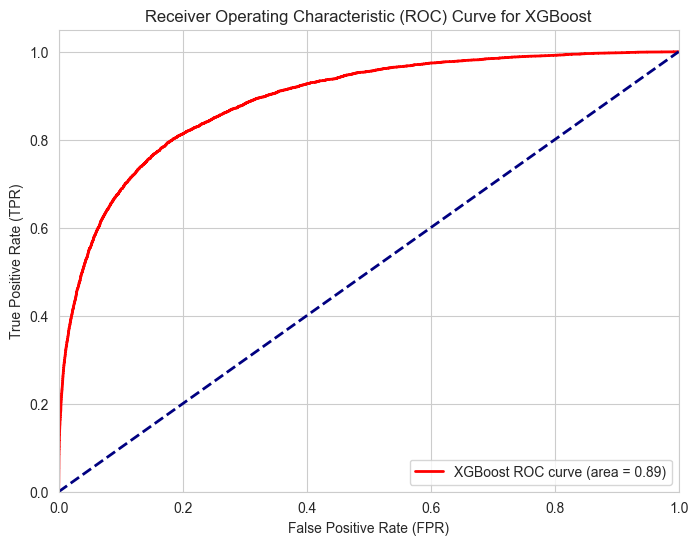

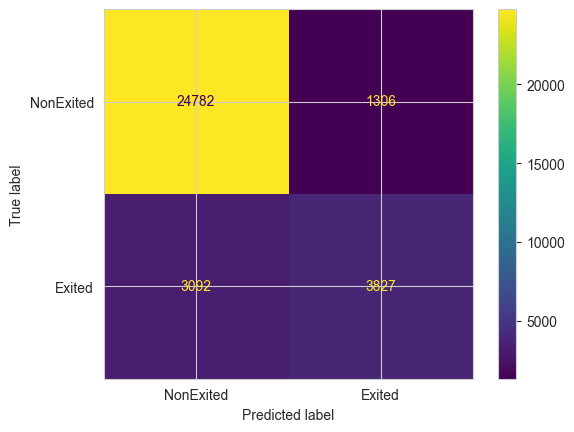

In [32]:
# predict under best parameter
best_params = best_xgb_study.best_params
best_xgb_model = XGBClassifier(**best_params, eval_metric='logloss')
best_xgb_model.fit(X_train, y_train)
y_prob2 = best_xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob2 > 0.5).astype(int)
print(classification_report(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_prob2)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'XGBoost ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['NonExited','Exited'])
plt.show()

In [34]:
# def catboost_optimise(trial):
#     depth = trial.suggest_int('depth', 4, 10)
#     learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
#     l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
#     iterations = trial.suggest_int('iterations', 100, 500)
# 
#     model = CatBoostClassifier(
#         depth=depth,
#         learning_rate=learning_rate,
#         l2_leaf_reg=l2_leaf_reg,
#         iterations=iterations,
#         class_weights=[(y_train == 0).sum() / len(y_train), (y_train == 1).sum() / len(y_train)],
#         verbose=0,
#         random_state=42
#     )
#     model.fit(X_train, y_train)
#     y_prob3 = model.predict_proba(X_test)[:,1]
#     y_pred = (y_prob3 > 0.5).astype(int)
#     accuracy = accuracy_score(y_test, y_pred)
#     return accuracy
# 
# catboost_study = optuna.create_study(direction='maximize')
# catboost_study.optimize(catboost_optimise, n_trials=50)
# print(f"Best Accuracy: {catboost_study.best_value}")
# print(f"Best CatBoost Hyperparameters: {catboost_study.best_params}")

In [35]:
# best_params = catboost_study.best_params
# best_catboost_model = CatBoostClassifier(**best_params, verbose=0)
# best_catboost_model.fit(X_train, y_train)
# y_prob3 = best_catboost_model.predict_proba(X_test)[:, 1]
# y_pred = (y_prob3 > 0.5).astype(int)
# print(classification_report(y_test, y_pred))
# fpr, tpr, _ = roc_curve(y_test, y_prob3)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='red', lw=2, label=f'CatBoost ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('Receiver Operating Characteristic (ROC) Curve for CatBoost')
# plt.legend(loc="lower right")
# plt.show()
# ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['NonExited','Exited'])
# plt.show()

Voting System Confusion Matrix


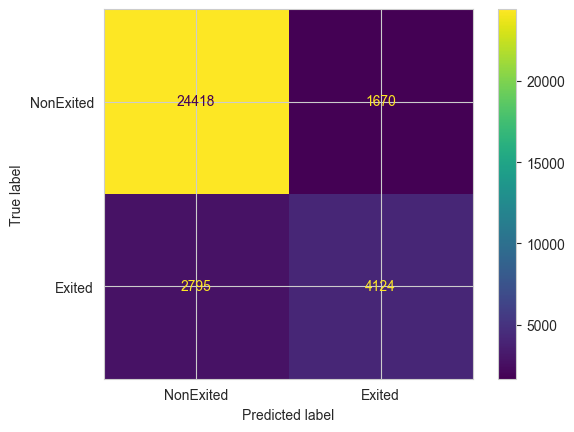

Voting System Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     26088
           1       0.71      0.60      0.65      6919

    accuracy                           0.86     33007
   macro avg       0.80      0.77      0.78     33007
weighted avg       0.86      0.86      0.86     33007



In [36]:
soft_voting = VotingClassifier(estimators=[
    ('lr', best_rf_model), ('dt', best_xgb_model)], voting='soft')
soft_voting.fit(X_train, y_train)
soft_voting_pred = soft_voting.predict(X_test)
print('Voting System Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, soft_voting_pred, display_labels=['NonExited', 'Exited'])
plt.show()
print('Voting System Classification Report')
print(classification_report(y_test, soft_voting_pred))

The best f1-score: 0.6606417812704649, threshold: 0.34
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     26088
           1       0.60      0.73      0.66      6919

    accuracy                           0.84     33007
   macro avg       0.76      0.80      0.78     33007
weighted avg       0.86      0.84      0.85     33007



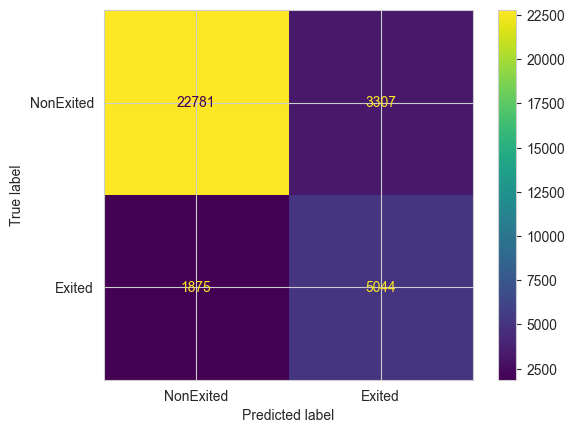

In [37]:
soft_proba = soft_voting.predict_proba(X_test)[:,1]
# find the best threshold
threshold = 0
best_f1 = 0
for threshold in np.arange(0.0, 1.0, 0.01):
    y_pred = (soft_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"The best f1-score: {best_f1}, threshold: {best_threshold}")
y_pred = (soft_proba > best_threshold).astype(int)
print(classification_report(y_test, y_pred))
print('Confusion Matrix after optimisation')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['NonExited', 'Exited'])
plt.show()